In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Establishing baseline w.r.t PCA

In [11]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
net = PCAAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')


start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)

ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186


ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186
Time taken for fitting with 30 epochs: 0:04:43.255647
Time taken to transform: 23.56
Reconstruction error: 17.841055


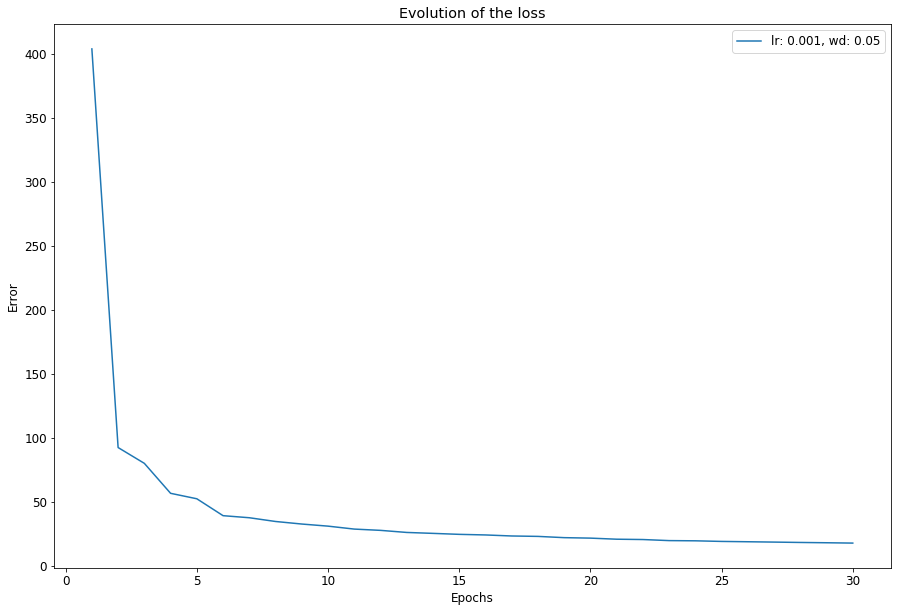

In [15]:
ncomp = 50
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
net = PCAAutoEncoder((video.width, video.height), ncomp)
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')


start = time()
losses = []
for i in range(num_epoch):
    epoch_loss = 0
    num_batch  = 0
    for x in video:
        num_batch += 1
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    losses.append(epoch_loss / num_batch)
fitting_time = sec2string(time() - start)

video.randit = video.skip_frame = 0
start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = sec2string(time() - start)

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print(f'Time taken for fitting with {num_epoch} epochs:', fitting_time)
print('Time taken to transform:', transform_time)

print('Reconstruction error:', exact_loss)
losses = np.array(losses)
plot(range(1, num_epoch+1), [losses], title='Evolution of the loss', xlabel='Epochs', ylabel='Error', labels=['lr: 0.001, wd: 0.05'])

As a comparison for PCA:
Error of 7.45 after 36s of fitting time

In [16]:
write_video('data/big_sample_pcaae_50.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)